In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

# from py21cmfish.power_spectra import *
# from py21cmfish.io import *
# import py21cmfast as p21c
from scipy import stats

# 21cmFAST
import py21cmfast as p21c
from py21cmfast import plotting, cache_tools
print(f'Using 21cmFAST version {p21c.__version__}')

import logging
logger = logging.getLogger('21cmFAST')
logger.setLevel(logging.INFO)

Default cache dir: /n/netscratch/iaifi_lab/Lab/yitians/dm21cm/21cmFAST-cache
Using 21cmFAST version 0.1.dev1586+g6f60f17


/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:59: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:43: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


In [2]:
###########################
# Setup Plotting Defaults #
###########################
# For more options see https://matplotlib.org/users/customizing.html

# Line styles
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.antialiased'] = True
mpl.rcParams['lines.dashed_pattern'] = 2.8, 1.5
mpl.rcParams['lines.dashdot_pattern'] = 4.8, 1.5, 0.8, 1.5
mpl.rcParams['lines.dotted_pattern'] = 1.1, 1.1
mpl.rcParams['lines.scale_dashes'] = True

# Default colors
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler('color',['cornflowerblue','forestgreen','maroon','goldenrod','firebrick','mediumorchid', 'navy', 'brown'])


# Fonts
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'CMU Serif'
mpl.rcParams['font.sans-serif'] = 'CMU Sans Serif, DejaVu Sans, Bitstream Vera Sans, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif'
mpl.rcParams['text.usetex'] = True

# Axes
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['axes.labelpad'] = 9.0
                                                  
                                                  
# Tick marks - the essence of life
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['xtick.major.pad'] = 8
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['ytick.minor.width'] = 0.75
mpl.rcParams['ytick.major.pad'] = 8
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.minor.visible'] = True

# Legend
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 1.
#mpl.rcParams['legend.edgecolor'] = 'black'
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.borderpad'] = 0.4 # border whitespace
mpl.rcParams['legend.labelspacing'] = 0.5 # the vertical space between the legend entries
mpl.rcParams['legend.handlelength'] = 1.5 # the length of the legend lines
mpl.rcParams['legend.handleheight'] = 0.7 # the height of the legend handle
mpl.rcParams['legend.handletextpad'] = 0.5 # the space between the legend line and legend text
mpl.rcParams['legend.borderaxespad'] = 0.5 # the border between the axes and legend edge
mpl.rcParams['legend.columnspacing'] = 2.0 # column separation


# Save details
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.pad_inches'] = 0.1

# Power Spectr

In [3]:
import powerbox
import importlib

importlib.reload(powerbox)

<module 'powerbox' from '/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/powerbox/__init__.py'>

In [4]:
def compute_power(
   box,
   length,
   n_psbins,
   log_bins=True,
   ignore_kperp_zero=True,
   ignore_kpar_zero=False,
   ignore_k_zero=False,
):
    # Determine the weighting function required from ignoring k's.
    k_weights = np.ones(box.shape, int)
    n0 = k_weights.shape[0]
    n1 = k_weights.shape[-1]

    if ignore_kperp_zero:
        k_weights[n0 // 2, n0 // 2, :] = 0
    if ignore_kpar_zero:
        k_weights[:, :, n1 // 2] = 0
    if ignore_k_zero:
        k_weights[n0 // 2, n0 // 2, n1 // 2] = 0

    res = powerbox.tools.get_power(
        box,
        boxlength=length,
        bins=n_psbins,
        bin_ave=False,
        get_variance=False,
        log_bins=log_bins,
        k_weights=k_weights,
    )

    res = list(res)
    k = res[1]
    if log_bins:
        k = np.exp((np.log(k[1:]) + np.log(k[:-1])) / 2)
    else:
        k = (k[1:] + k[:-1]) / 2

    res[1] = k
    return res

def powerspectra(brightness_temp, n_psbins=50, nchunks=20, min_k=0.1, max_k=1.0, logk=True):
    data = []
    chunk_indices = list(range(0,brightness_temp.n_slices,round(brightness_temp.n_slices / nchunks),))    
    
    if len(chunk_indices) > nchunks:
        chunk_indices = chunk_indices[:-1]
    chunk_indices.append(brightness_temp.n_slices)
    
    nchunks = 20
    chunk_indices = np.searchsorted(rs, np.arange(nchunks+1)*2+5)
    print(rs[np.minimum(len(rs)-1, chunk_indices)])

    for i in range(nchunks):
        start = chunk_indices[i]
        end = chunk_indices[i + 1]
        chunklen = (end - start) * brightness_temp.cell_size

        power, k = compute_power(
            brightness_temp.brightness_temp[:, :, start:end],
            (BOX_LEN, BOX_LEN, chunklen),
            n_psbins,
            log_bins=logk,
        )
        data.append({"k": k, "delta": power * k ** 3 / (2 * np.pi ** 2)})
    return data

In [5]:
BOX_LEN = 256
HII_DIM = 128


k_fundamental = 2*np.pi/BOX_LEN
k_max = k_fundamental * HII_DIM
Nk=np.floor(HII_DIM/1).astype(int)

In [7]:
outputs_dir = "/n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs"
lightcone = p21c.LightCone.read(f"{outputs_dir}/bkg/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_fid_r54321.h5")
rs = lightcone.lightcone_redshifts
rs = np.array(rs)

In [8]:
nchunks = 15
brightness_temp = lightcone
chunk_indices = list(range(0,brightness_temp.n_slices,round(brightness_temp.n_slices / nchunks),))    

if len(chunk_indices) > nchunks:
    chunk_indices = chunk_indices[:-1]
chunk_indices.append(brightness_temp.n_slices)


chunk_indices = np.minimum(chunk_indices, len(rs)-1)
redshift_times = np.around(rs[chunk_indices], 1)

In [ ]:
outputs_dir = "/n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs"
dirs = {
    'decay' : "/decay/phot/log10m5.000",
    'pwave' : "/pwave-phot-iter-a/log10m5.000",
    'pbh-hr' : "/pbh-hr/log10m16.500",
    "pbh-acc" : "/pbh-acc-PRc23-test/log10m2.000",
}
bkg_fn = f"{outputs_dir}/bkg/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_fid_r54321.h5"
inj_fn = "LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_DM_1_r54321.h5"

In [18]:
type(lightcone.brightness_temp)

numpy.ndarray

In [25]:
outputs_dir = "/n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs"



# lightcone = p21c.LightCone.read(f"{outputs_dir}/decay/phot_hom/Mass3/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_DM_2_r54321.h5")
# out_hom = powerspectra(lightcone, min_k = k_fundamental, max_k = k_max)

lc_bkg = p21c.LightCone.read(f"{outputs_dir}/bkg/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_fid_r54321.h5")
out_null = powerspectra(lc_bkg, min_k = k_fundamental, max_k = k_max)

ms = [28.009630589944866,520.2646202699127,29.878273027065635,38.4315258610579]


lc = p21c.LightCone.read(f"{outputs_dir}/pbh-acc-PRc23-test/log10m2.000/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_DM_2_r54321.h5")
lc.brightness_temp = (lc.brightness_temp - lc_bkg.brightness_temp) * ms[3] + lc_bkg.brightness_temp
out_fid = powerspectra(lc, min_k = k_fundamental, max_k = k_max)

[ 5.00000001  7.00329196  9.00798243 11.00747293 13.00059925 15.00471853
 17.00067211 19.00545741 21.02206528 23.02955914 25.02067146 27.00640901
 29.02001871 31.0290245  33.04536855 35.03891719 37.03469253 39.00865587
 41.00274622 43.00207026 45.06889177]
[ 5.00000001  7.00329196  9.00798243 11.00747293 13.00059925 15.00471853
 17.00067211 19.00545741 21.02206528 23.02955914 25.02067146 27.00640901
 29.02001871 31.0290245  33.04536855 35.03891719 37.03469253 39.00865587
 41.00274622 43.00207026 45.06889177]


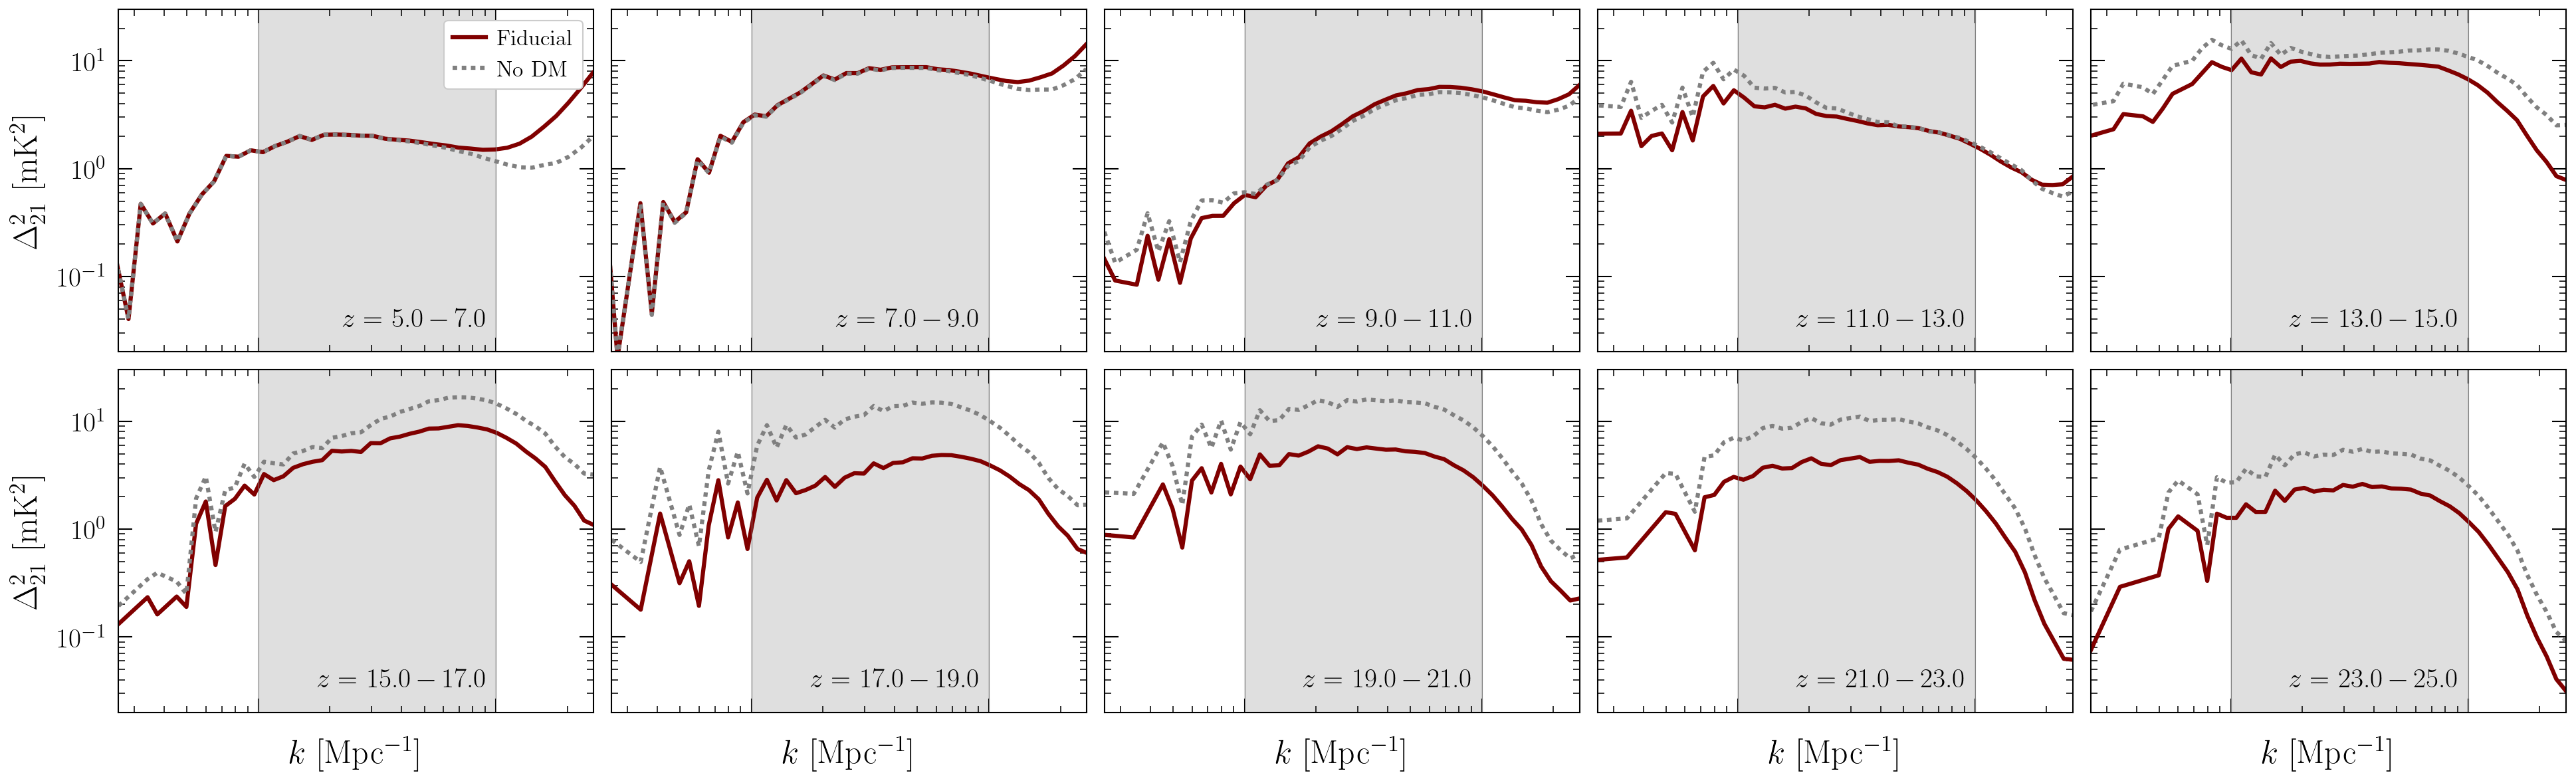

In [26]:
fig, axs = plt.subplots(ncols = 5, nrows = 2, figsize = (26, 8), sharey=True, sharex=True)

for i in range(10):
    
    row_index, col_index = np.unravel_index(i, axs.shape)
    ax = axs[row_index, col_index]
    
    # Fiducial 
    x, y_fid = out_fid[i]['k'], out_fid[i]['delta']
    # _, y_hom = out_hom[i]['k'], out_hom[i]['delta']
    x, y_null = out_null[i]['k'], out_null[i]['delta']
    
    locs = np.where(np.logical_not(np.isnan(y_fid)))
    ax.plot(x[locs], y_fid[locs], color = 'maroon', lw = 3, label = 'Fiducial')
    # ax.plot(x[locs], y_hom[locs], color = 'black', lw = 3, label = 'Homogeneous', ls = '--')
    ax.plot(x[locs], y_null[locs], color = 'grey', lw = 3, label = 'No DM', ls = ':')
    
    # ax.set_ylim(np.nanmax([np.nanmin(y_fid), np.nanmin(y_hom), np.nanmin(y_null)]),
    #             1.5*np.nanmax([np.nanmax(y_fid), np.nanmax(y_hom), np.nanmax(y_null)]))
    ax.set_ylim(np.nanmax([np.nanmin(y_fid), np.nanmin(y_null)]),
                1.5*np.nanmax([np.nanmax(y_fid), np.nanmax(y_null)]))
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    if i < 10:
        ax.text(.775, .075, '$z =$ ' + str(float(6+2*i-1)) + r'$\,-\,$' + str(float(6+2*i+1)),
                transform=ax.transAxes, fontsize = 20, horizontalalignment= 'right')
    else:
        ax.text(.775, 1-.125, '$z =$ ' + str(float(6+2*i-1)) + r'$\,-\,$' + str(float(6+2*i+1)),
                transform=ax.transAxes, fontsize = 20, horizontalalignment= 'right')
        
    ax.set_xlim(x[locs][0], x[locs][-1])
    ax.axvspan(.1, 1, color = 'grey', alpha = .25)
    ax.axvline(.1, color = 'grey', lw = .5)
    ax.axvline(1, color = 'grey', lw = .5)

for i in range(axs.shape[0]-1):
    for j in range(axs.shape[1]):
        axs[i, j].set_xticklabels([])

for j in range(axs.shape[1]):
    axs[-1, j].set_xlabel('$k$ [Mpc$^{-1}$]', fontsize = 24)
for i in range(axs.shape[0]):
    axs[i, 0].set_ylabel('$\Delta^2_{21}$ [mK$^{2}$]', fontsize = 24)
    
for i in range(5):
    axs[0, i].set_ylim(2e-2, 3e1)
    axs[1, i].set_ylim(2e-2, 3e1)

axs[0, 0].legend(loc = 'upper right', fontsize = 16, ncol = 1)
plt.tight_layout()
# plt.savefig('plots/ps_small_inj.pdf')
# plt.show()